In [2]:
from data import generate_dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

n = 1000

x, y, y_noisy = generate_dataset(n=n, noise_std=0.5, random_state=1)

In [3]:


def train_torch(
    X_train, y_train, X_test, y_test,
    layers=[1,10,1],
    activation=nn.Sigmoid(),
    lr=0.01,
    num_steps=1000,
    batch_size=32,
    device='cpu'
):
    # convert to torch
    X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
    y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
    X_test  = torch.tensor(X_test,  dtype=torch.float32, device=device)
    y_test  = torch.tensor(y_test,  dtype=torch.float32, device=device)

    # build layers
    L = []
    for i in range(len(layers)-1):
        L.append(nn.Linear(layers[i], layers[i+1]))
        if i < len(layers)-2:
            L.append(activation)          # hidden activations
    model = nn.Sequential(*L).to(device)

    opt = torch.optim.Adam(model.parameters(),
                           lr=lr,
                           betas=(0.9,0.999),
                           eps=1e-8)
    loss_fn = nn.MSELoss()

    ds = TensorDataset(X_train, y_train)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True)

    train_mse = []
    test_mse  = []

    step = 0
    while step < num_steps:
        for xb,yb in dl:
            step += 1

            pred = model(xb)
            loss = loss_fn(pred, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

            # record MSEs
            with torch.no_grad():
                train_mse.append(loss_fn(model(X_train), y_train).item())
                test_mse.append(loss_fn(model(X_test),  y_test ).item())

            if step >= num_steps:
                break

    return model, train_mse, test_mse


In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y_noisy, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 1))
x_test_scaled = scaler.transform(x_test.reshape(-1, 1))

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

model, train_curve, test_curve = train_torch(
    x_train_scaled, y_train, x_test_scaled, y_test,
    layers=[1,10,1],
    activation=nn.Sigmoid(),
    lr=0.01,
    num_steps=1000,
    batch_size=32
)


In [5]:
print("Final test MSE:", test_curve[-1])

Final test MSE: 0.241007462143898


Layers=0, nodes=5 -> Test MSE=0.30725
Layers=0, nodes=10 -> Test MSE=0.30769
Layers=0, nodes=25 -> Test MSE=0.30776
Layers=0, nodes=50 -> Test MSE=0.30781
Layers=0, nodes=100 -> Test MSE=0.30718
Layers=1, nodes=5 -> Test MSE=0.23437
Layers=1, nodes=10 -> Test MSE=0.23121
Layers=1, nodes=25 -> Test MSE=0.23368
Layers=1, nodes=50 -> Test MSE=0.23308
Layers=1, nodes=100 -> Test MSE=0.23760
Layers=2, nodes=5 -> Test MSE=0.23771
Layers=2, nodes=10 -> Test MSE=0.23934
Layers=2, nodes=25 -> Test MSE=0.22917
Layers=2, nodes=50 -> Test MSE=0.23573
Layers=2, nodes=100 -> Test MSE=0.23162
Layers=3, nodes=5 -> Test MSE=0.23061
Layers=3, nodes=10 -> Test MSE=0.24314
Layers=3, nodes=25 -> Test MSE=0.23078
Layers=3, nodes=50 -> Test MSE=0.24067
Layers=3, nodes=100 -> Test MSE=0.23350


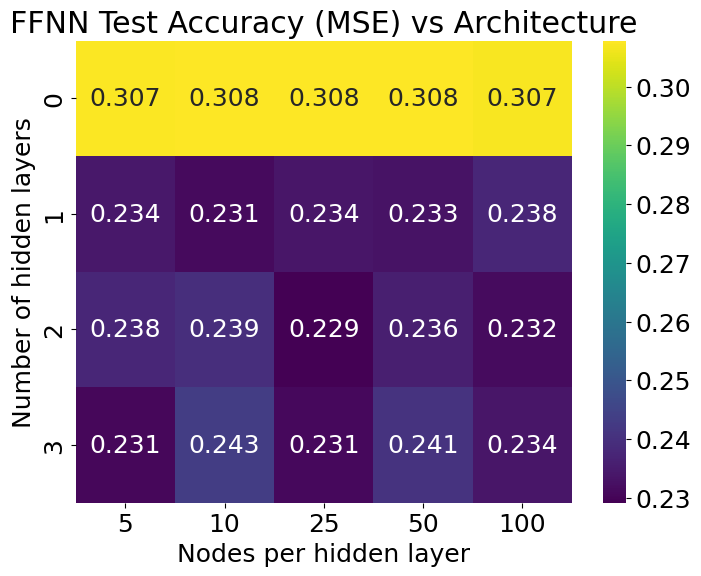

In [7]:
hidden_layers_list = [0, 1, 2, 3]
nodes_list = [5, 10, 25, 50, 100]

results = np.zeros((len(hidden_layers_list), len(nodes_list)))

for i, n_layers in enumerate(hidden_layers_list):
    for j, n_nodes in enumerate(nodes_list):
        # build layer structure dynamically
        if n_layers == 0:
            layers = [1, 1]
        else:
            layers = [1] + [n_nodes]*n_layers + [1]

        model, tr, te = train_torch(
            X_train=x_train_scaled,
            y_train=y_train,
            X_test=x_test_scaled,
            y_test=y_test,
            layers=layers,
            activation=nn.Sigmoid(),   
            lr=0.01,
            num_steps=1500,
            batch_size=32
        )

        results[i,j] = te[-1]
        print(f"Layers={n_layers}, nodes={n_nodes} -> Test MSE={te[-1]:.5f}")

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,6))
sns.heatmap(results, annot=True, fmt=".3f", cmap="viridis",
            xticklabels=nodes_list,
            yticklabels=hidden_layers_list)
plt.xlabel("Nodes per hidden layer")
plt.ylabel("Number of hidden layers")
plt.title("FFNN Test Accuracy (MSE) vs Architecture")
plt.show()
